# Introduction to physics informed neural networks

This example, inspired by [this repo](https://github.com/benmoseley/harmonic-oscillator-pinn), introduces physics informed neural networks using pytorch. Here, we will learn the dynamics of a 1D dampened harmonic oscillator with unit mass, spring constant $k$ and dampening constant $\mu$:
$$
\dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~.
$$


Exercises:

(a) Run sections 1 and 2. It should work out of the box. Understand how the neural network is learning the dynamics and what are its short comings? Experiment with the hyperparameters and data parameters.

(b) Train a physics informed neural network on the same data and plot the results. Experiment with hyper parameters and data parameters. (Section 3)

(c) Train a physics informed neural network but learn the parameters $\mu$ and $k$ (i.e., treat them as unknown parameters, section 4). 

(d) Add noise and repeat the experiments.

In [1]:
try:
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import torch.nn as nn
except ModuleNotFoundError:
    %pip install -r requirements.txt 


np.random.seed(0)
torch.random.manual_seed(0)

plt.rcParams['font.size'] = 16
plt.rcParams['lines.markersize'] = 10


### 1. Exact solution and data
For the underdampened case, $\mu^2 < 4 k~,$ the exact solution is given by 
$$
x(t) = e^{-\delta t}(A \cos(\phi + \omega t)),
$$
where $\omega=\frac{1}{2}\sqrt{4k - \mu^2}$ and the constants $A$ and $\phi$ determine the initial conditions. We will set $A=1$ and $\phi=0$. In practice however, we are given a data set that is the solution of a differential equation and we make the *assumption* that the differential equation is of a known form (i.e., we know the physical equations, possibly with some unknown constants that can be learned).

Let's turn the above exact solution into a function that we can use to generate a training data set $X_{\mathrm{train}}$ consisting of points $(t_i, x_i)$, where $t_i$ are evenly spaced times on some interval and $x_i=x(t_i)$ is given by the above exact solution. We wil also create a test data set $X_{\mathrm{test}}$ on a longer time interval. 

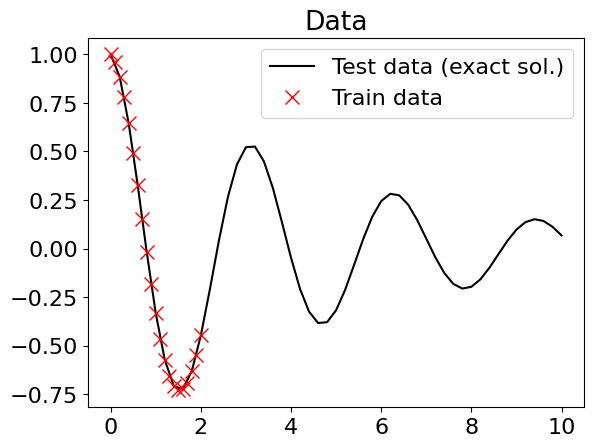

In [2]:
# ODE parameters
MU = 0.4
K = 4

# Data generation parameters
N_TRAIN = 20
TMAX_TRAIN = 2

N_TEST = 50
TMAX_TEST = 10


def exact_solution(t, k=K, mu=MU):
    """Get exact solution to the 1D underdamped harmonic oscillator."""
    assert mu**2 < 4 * k, "System must be underdamped."
    w = np.sqrt(4 * k - mu**2) / 2
    x = torch.exp(-mu / 2 * t) * torch.cos(w * t)
    return x


t_train = torch.linspace(0, TMAX_TRAIN, N_TRAIN + 1).unsqueeze(-1)
t_test = torch.linspace(0, TMAX_TEST, N_TEST + 1).unsqueeze(-1)

x_train = exact_solution(t_train)
x_test = exact_solution(t_test)

plt.plot(t_test, x_test, "k-", label="Test data (exact sol.)")
plt.plot(t_train, x_train, "rx", label="Train data")
plt.title("Data")
plt.legend()

### 2. Learning the dynamics with a ***basic neural network*** 
Now we will set up a neural network $x_\theta(t)$ to learn the dynamics $x(t)$ from the training data. We hope that it will generalise well to the test data, which is the exact solution over a longer time span. 

We do this by training the neural network on a loss function that minimises the mean squared error (MSE) between the predicted solution $x_{\theta}(t_i)$ and the observed (exact solution) values $(t_i, x_i)\in X_{\mathrm{train}}$. 

$$L_{\mathrm{data}} = \sum_{(t_i, x_i)\in X_{\mathrm{train}}}\|x_{\theta}(t_i) - x_i\|^2$$

loss = 0.4853847920894623
loss = 3.1892901461105794e-05
loss = 1.205876196763711e-05
loss = 7.332176664931467e-06
loss = 4.8083143155963626e-06
loss = 3.1590857361152302e-06
loss = 2.2165661448525498e-06
loss = 1.4700562132929917e-05
loss = 1.3623196082335198e-06
loss = 1.0583211178527563e-06
loss = 8.587029469708796e-07
loss = 5.6175131248892285e-06
loss = 7.473385608136596e-07
loss = 6.294040986176697e-07
loss = 6.246607995308295e-07
loss = 3.913074397132732e-05
loss = 5.008631660530227e-07
loss = 4.891773528470367e-07
loss = 6.10415440860379e-07
loss = 4.6382487539631256e-07


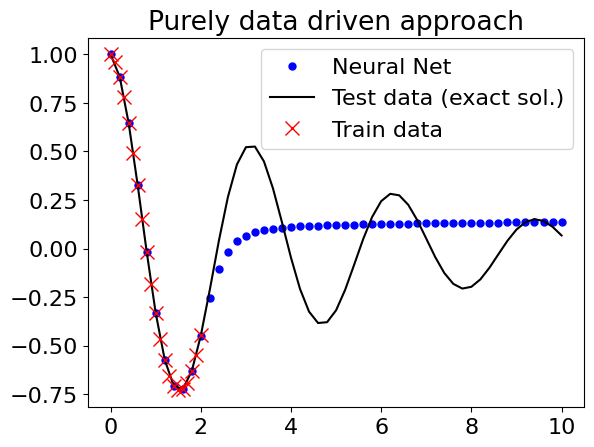

In [3]:
class NeuralNet(nn.Module):
    """Defines a pytorch neural network with one hidden layer."""

    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        return self.network(x)


def train_nn(model, t_train, x_train, nepochs=10000, learning_rate=5e-3):
    mse = nn.MSELoss()
    torch.manual_seed(123)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for i in range(nepochs):
        optimizer.zero_grad()

        # compute data loss
        x_pred = model(t_train)
        loss = mse(x_pred, x_train)

        # backward pass and update parameters
        loss.backward()
        optimizer.step()

        print(f"loss = {loss.item()}") if i % 500 == 0 else None


model_nn = NeuralNet()
train_nn(model_nn, t_train=t_train, x_train=x_train)

plt.plot(t_test, model_nn(t_test).detach().numpy(), "b.", label="Neural Net")
plt.plot(t_test, x_test, "k-", label="Test data (exact sol.)")
plt.plot(t_train, x_train, "rx", label="Train data")
plt.title("Purely data driven approach")
plt.legend()

### 3. Learning the dynamics with a ***physics informed neural network***
Now we will train the physics informed neural network (PINN). This is done in exactly the same way as before, but we augment the loss function with the "physics loss".

$$L_{\mathrm{PINN}}=L_{\mathrm{data}} + \lambda L_{\mathrm{phys.}}$$
where $\lambda$ is a hyper parameter
$$L_{\mathrm{phys.}} = \sum_{t_i\in X_{\mathrm{phys.}}}\|\ddot{x}_{\theta}(t_i)+ \mu\,\dot{x}_{\theta}(t_i) + k\,x_{\theta}(t_i)\|^2,$$
where $X_{\mathrm{phys.}}$ are a set of times, chosen by us, that we choose to evaluate the *physics loss* on 

In [4]:
# choose points to evaluate the physics loss with
def time_derivative(x, t):
    """Returns the time derivative of x at times t using automatic differentiation.
    Example: 
        t = torch.linspace(0, 1, 10)
        x = model(t)
        xdot = time_derivative(x, t)"""
    xdot = torch.autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    return xdot

def train_pinn(model, t_train, x_train, t_phys, nepochs=10000, learning_rate=5e-3):
    # write this function! It will look similar to train_nn above one but some key differences
    ...

In [5]:
# plot the results

### 4. Learning the parameters $\mu$ and $k$

What we have just done was solve the forward problem. Traditional numerics usually beats PINNs in terms of cost and accuracy. However, the scenario where PINNs outperforms traditional numerics is when we have ***partial*** knowledge of the governing equations. 

Say that the parameters $\mu$ and $k$ are unknown. Using the data (which encodes the values of $\mu$ and $k$) together with knowledge that the governing ODE is partially known, we can treat $\mu$ and $k$ as learnable parameters and adopt the same approach as before. 

### 5. Add noise! 

Go back to the data generation step and add noise to the training data. See how the models compare. 